In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def print_rxn(model,rxn_id):
    rxn = model.reactions.get_by_id(rxn_id)
    print(rxn.id)
    print(rxn.name)
    eq = rxn.reaction
    for met in rxn.metabolites: eq = eq.replace(met.id,met.name+'_'+met.compartment)
    print(eq)
    print(rxn.gene_reaction_rule)
    print('')

In [3]:
def plot_a_flux(name,results,Ts,thr=0,label=None):
    X = list()
    Ts = np.arange(30,40,0.2) + 273.15
    for part in resutls: 
        f = [s.fluxes[name] for s in part]
        f.extend([np.nan]*(len(Ts)-len(f)))
        X.append(f)
    X = np.array(X)
    ps = np.nanpercentile(X,[5,50,95],axis=0)
    
    ps = ps[:,Ts<38.+273.15]
    Ts = Ts[Ts<38.+273.15]
    if np.max(ps[1,:])>thr: 
        plt.plot(Ts-273.15,ps[1,:],label=label)
        plt.fill_between(Ts-273.15,ps[0,:],ps[2,:],alpha=0.5)

        plt.xlim([30,39.])
        print_rxn(model,name)
    #plt.ylim(np.min(ps[0,:])*0.8, np.max(ps[2,:])*1.1)
    #plt.show()

In [4]:
def plot_paper_figure(results,Ts,outfile,xlim=[30,39],ylim1=[0,0.2],ylim2=[0,15],protein_lim=0.17866,figsize=(3,2.4)):
    
    
    r1 = 'prot_pool_exchange' # protein pool
    #r2 = 'r_1714_REV' # glucose
    #r3 = 'r_1761'     # ethanol
    #r4 = 'r_0962No1'
    rxn_labels = {
    'r_0446_REVNo1': 'ATP produced by ADE3 (C1 Metabolism)',
    'r_0892No1': 'ATP produced by PGK1 (Glycolysis)',
    'r_0962No1': 'ATP produced by CDC19 (Glycolysis)',
    'r_1110': 'ATP produced by Mitochondria'
    }
    colors = {
        'r_0446_REVNo1': '#1b9e77',
        'r_0892No1':'#d95f02',
        'r_0962No1': '#7570b3',
        'r_1110':'#e7298a'
    }
    
    def _do_plot(Ts,results,name,ax,label,scale=1,c=None):
        X = list()
        #Ts = np.arange(30,40,0.2) + 273.15
        for part in results: 
            f = [s.fluxes[name] for s in part]
            f.extend([np.nan]*(len(Ts)-len(f)))
            X.append(f)
            
        
        ps = np.nanpercentile(X,[5,50,95],axis=0)/scale

        #ps = ps[:,Ts<38.5+273.15]
        #Ts = Ts[Ts<38.5+273.15]
        ax.plot(Ts-273.15,ps[1,:],label=label,color=c)
        ax.fill_between(Ts-273.15,ps[0,:],ps[2,:],alpha=0.5,color=c)

        ax.set_xlim(xlim)
        #plt.ylim(np.min(ps[0,:])*0.8, np.max(ps[2,:])*1.1)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax1 = ax.twinx()
    for rxn_id, label in rxn_labels.items(): _do_plot(Ts,results,rxn_id,ax,label,c=colors[rxn_id])
    ax.plot([],[],label='Protein',color='k')
    ax.plot([],[],'--',label='Maximal protein amount',color='k')
    
    #_do_plot(r2,ax,'Glucose')
    #_do_plot(r3,ax,'Ethanol')
    _do_plot(Ts,results,r1,ax1,'Protein',0.5,'k')
    ax1.plot(xlim,[protein_lim]*2,'--',label=None,color='gray')
    ax1.set_ylim(ylim1)
    ax1.set_yticks(np.arange(0,ylim1[1]+0.05,0.05))
    ax.set_ylim(ylim2)
    ax.set_xlim(xlim)
    ax.legend(bbox_to_anchor=(0, 1.1, 1., 0.),loc='lower center', borderaxespad=0,fontsize=9.5,mode='expand')
    ax.set_ylabel('ATP (mmol/gDW/h)')
    ax1.set_ylabel('Protein amount (g/gDW)')
    ax.set_xlabel('Temperature ($^\circ$C)')
    
    plt.savefig(outfile,bbox_inches='tight')
    plt.show()

In [5]:
def get_fluxes_from_solutions(rxn_id,chemostats, Ts):
    # fluxes: 2d array, with temperature as columns and particles as rows
    fluxes = []
    for p in chemostats:
        lst = [s.fluxes[rxn_id] for s in p]
        if len(lst)<len(Ts): lst.extend([np.nan for i in range(len(Ts)-len(lst))])
        fluxes.append(lst)
    
    return np.array(fluxes)

In [6]:
results0 = pickle.load(open('../results/chemostat_solutions_all_particles.pkl','rb'))

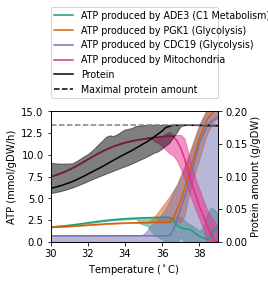

In [41]:
outfile = '../figures/atp_production_chemo.pdf'
Ts0 = np.arange(30,40,0.2) + 273.15
plot_paper_figure(results0,Ts0,outfile)

#### when increase the protein limit

In [7]:
[TsPL,results_double_PL] = pickle.load(open('../results/chemostat_double_protein_limt.pkl','rb'))

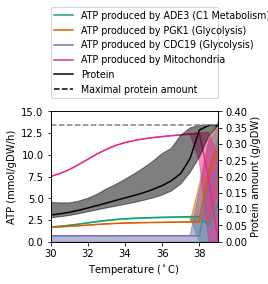

In [37]:
plot_paper_figure(results_double_PL,TsPL+273.15,'../figures/atp_production_chemo_doublePL.pdf',
                 xlim=[30,39],
                 ylim1=[0,0.4],
                 protein_lim=0.17866*2)

In [8]:
[Ts2,results2] = pickle.load(open('../results/chemostat_stable_mito.pkl','rb'))

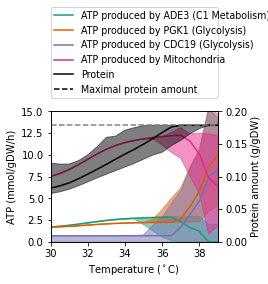

In [39]:
plot_paper_figure(results2,Ts2+273.15,'../figures/atp_production_chemo_stable_mito.pdf')

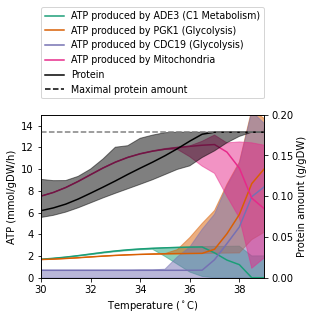

In [38]:
plot_paper_figure(results2,Ts2+273.15,'../figures/atp_production_chemo_stable_mito_large.pdf',figsize=(4,3))

#### Compare ATP flux at two conditions

In [9]:
def _plot_confidence_interval(ax,x, data,label=None):
    y = np.array(data)
    
    yp = np.percentile(y,[5,50,95],axis=0)
    print(len(x),y.shape,yp.shape)
    ax.plot(x,yp[1,:],label=label)
    ax.fill_between(x,yp[0,:],yp[2,:],alpha=0.5)
    
    return yp[1,:]

In [23]:
def compare_atp_from_mito(res1,res2,res3,Ts1,Ts2,Ts3):
    
    def get_flux(results,Ts):
        name = 'r_1110'
        x = list()
        #Ts = np.arange(30,40,0.2) + 273.15
        for part in results: 
            f = [s.fluxes[name] for s in part]
            f.extend([np.nan]*(len(Ts)-len(f)))
            x.append(f)
        return x
    
    x1 = get_flux(res1,Ts1)
    x2 = get_flux(res2,Ts2)
    x3 = get_flux(res3,Ts3)
    
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    ax1 = ax.twinx()
    
    y1 = _plot_confidence_interval(ax, Ts1,x1,'Original')
    y2 = _plot_confidence_interval(ax, Ts2,x2,'Stablize mitochondrial enzymes')
    y3 = _plot_confidence_interval(ax, Ts3,x3,'Double the total protein limit')
    
    ax.set_xlabel('Temperature ($^\circ$C)')
    ax.set_ylabel('ATP from Mitochondria(mmol/gDW/h)')
    ax.legend()
    
    fold1 = y2[np.arange(0,len(Ts2),2)][:10]/y1[np.arange(0,len(Ts1),5)]
    Ts_fold1 = Ts1[np.arange(0,len(Ts1),5)]
    
    fold2 = y3[np.arange(0,len(Ts3),2)][:10]/y1[np.arange(0,len(Ts1),5)]
    Ts_fold2 = Ts1[np.arange(0,len(Ts1),5)]
    
    #ax1.plot(Ts_fold,fold)
    print(fold1)
    print(fold2)
    
    plt.tight_layout()
    plt.savefig('../figures/compare_atp_production_stable_and_original.png',dpi=300)
    plt.show()
            

In [15]:
res1 = pickle.load(open('../results/chemostat_solutions_all_particles.pkl','rb'))
[Ts2,res2] = pickle.load(open('../results/chemostat_stable_mito.pkl','rb'))

In [16]:
Ts0 = np.arange(30,40,0.2) 

/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/lib/function_base.py:3652 RuntimeWarning: Invalid value encountered in percentile
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/lib/function_base.py:3652 RuntimeWarning: Invalid value encountered in percentile
/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/lib/function_base.py:3652 RuntimeWarning: Invalid value encountered in percentile


50 (100, 50) (3, 50)
30 (100, 30) (3, 30)
30 (100, 30) (3, 30)
[1.         0.99999997 0.99999998 0.99999997 0.99999996 1.00000002
 0.99999947 1.13992798 2.46100664        nan]
[0.99999951 0.99999908 1.00000095 1.         0.99999994 0.99999969
 1.00000087 1.14318232 3.04678114        nan]


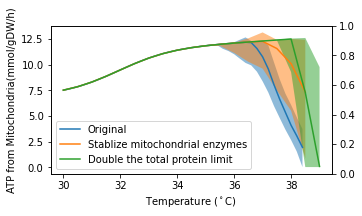

In [24]:
compare_atp_from_mito(res1,res2, results_double_PL, Ts0,Ts2,TsPL)

In [17]:
len(res1[0]),len(res2[0])

(50, 29)

In [49]:
Ts0[np.arange(0,len(Ts0),5)]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])

In [51]:
Ts2[np.arange(0,len(Ts2),2)][:10]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])

In [12]:
TsPL[np.arange(0,len(Ts2),2)][:10]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])

### P/O 

NDI1: P32340  
NDE1: 	P40215  
NDE2: 	Q07500  

In [48]:
def compare_PO(results,Ts):
    
    def get_flux(results,Ts,name):
        x = list()
        #Ts = np.arange(30,40,0.2) + 273.15
        for part in results: 
            f = [s.fluxes[name] for s in part]
            f.extend([np.nan]*(len(Ts)-len(f)))
            x.append(f)
        return np.array(x)
    
    
    ndi1 = 'r_0773No1'
    nde1 = 'r_0770No2'
    nde2 = 'r_0770No1'
        
    atpsyn = 'r_0226No1'
    
    ndi1_fx = get_flux(results,Ts,ndi1)
    nde1_fx = get_flux(results,Ts,nde1)
    nde2_fx = get_flux(results,Ts,nde2)
    atpsyn_fx = get_flux(results,Ts,atpsyn)
    
    po = atpsyn_fx/(ndi1_fx+nde1_fx+nde2_fx)
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)

    
    y1 = _plot_confidence_interval(ax, Ts,po,None)
    
    ax.set_xlabel('Temperature ($^\circ$C)')
    ax.set_ylabel('P/O')
    #plt.legend()
    
    
    plt.tight_layout()
    #plt.savefig('../figures/compare_atp_production_stable_and_original.png',dpi=300)
    plt.show()
            

50 (100, 50) (3, 50)


/apps/Vera/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.7/lib/python3.6/site-packages/numpy-1.15.0-py3.6-linux-x86_64.egg/numpy/lib/function_base.py:3652 RuntimeWarning: Invalid value encountered in percentile


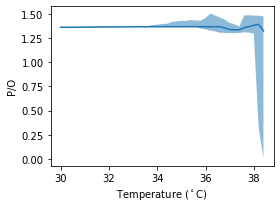

In [49]:
Ts0 = np.arange(30,40,0.2) 
compare_PO(results0,Ts0)

In [19]:
s0 = results0[0][0]

In [11]:
model = pickle.load(open('../models/aerobic.pkl','rb'))

In [18]:
compare_PO(results,Ts)

In [21]:
flux_in = s0.fluxes[ndi1] + s0.fluxes[nde1] + s0.fluxes[nde2]

In [35]:
flux_out = s0.fluxes['r_0226No1']

In [36]:
flux_out/flux_in

1.3623260932375985